In [ ]:
import numpy as np
import pandas as pd

path = "avg/"
sub_path = "d7/500-dmsp.xlsx"

host_path = "data/algae/" + path + sub_path
bacteria_path = "data/bacteria/" + path + sub_path

df_host = pd.read_excel(host_path, header=None)
df_bacteria = pd.read_excel(bacteria_path, header=None)
df_bacteria = df_bacteria.replace(0, np.nan)

df_host_time = df_host.iloc[:, 0]
host = df_host.iloc[:, 1].tolist()

df_bacteria_time = df_bacteria.iloc[:, 0]
bacteria = df_bacteria.iloc[:, 1].tolist()

time = df_host_time.tolist()
#time = time[1:]

log_host = np.log(np.array(host) + 1e-9)
log_bacteria = np.log(np.array(bacteria) + 1e-9)

save_path = "figures/0-path/" + host_path.replace("/", "_")
save_path = save_path[:-5].replace("data_algae_", "").strip()


In [17]:
bacteria_path

'data/bacteria/avg/d7/10-dmsp.xlsx'

In [18]:
bacteria

[1000.0,
 302602.3092951652,
 3938592.5384499766,
 6233290.531870245,
 8146044.211094533,
 11753175.015686994,
 30810607.200554203,
 56123622.15153634,
 72767759.200319,
 101323938.0494895,
 107215346.57537222,
 145807113.86329532]

In [19]:
def ode_system(t, y, params):
    H = y[0]
    B = y[1]
    P = y[2]

    muH = params[0]
    muB = params[1]
    k = params[2]
    phi = params[3]
    beta = params[4]

    dHdt = (muH * H * (1 - (H / k) )) - phi * H * P
    dPdt = beta * phi * H * P
    dBdt = muB * B
    return [dHdt, dBdt, dPdt]

In [20]:
import pytensor.tensor as pt
from pytensor.graph.op import Op
from scipy.integrate import solve_ivp

class SolveIVPWrapper(Op):
    itypes = [pt.dvector]  # theta + y0
    otypes = [pt.dmatrix]  # solution: (len(t), 3)

    def __init__(self, times):
        self.times = times

    def perform(self, node, inputs, outputs):
        theta_y0, = inputs
        theta = theta_y0[:5] # first 5
        y0 = theta_y0[5:] # last 3

        sol = solve_ivp(
            fun=lambda t, y: ode_system(t, y, theta),
            t_span=(self.times[0], self.times[-1]),
            y0=y0,
            t_eval=self.times,
            method="LSODA"
        )

        if not sol.success:
            raise RuntimeError("ODE solver failed:", sol.message)

        outputs[0][0] = sol.y.T  # shape: (time, 3)

In [ ]:
import pymc as pm

ode_op = SolveIVPWrapper(time)

with pm.Model() as model:
    muH = pm.Lognormal("muH", mu=np.log(0.73), sigma=.1)
    muB = pm.Uniform("muB", lower=0, upper=1)
    k = pm.Lognormal("k", mu=np.log(5e6), sigma=.1)
    phi = pm.Lognormal("phi", mu=np.log(7.1e-9), sigma=0.1)
    beta = pm.Uniform("beta", lower=0, upper=100)

    H0 = pm.Uniform("H0", lower=2e5, upper=1e7)
    B0 = pm.Uniform("B0", lower=2e4, upper=1e7)
    P0 = pm.Uniform("P0", lower=2e5, upper=6e7)
    
    sigma_host = pm.HalfNormal("sigma_host", sigma=1)
    sigma_bacteria = pm.HalfNormal("sigma_bacteria", sigma=1)

    ode_solution = ode_op(pt.stack([muH, muB, k, phi, beta, H0, B0, P0]))

    pm.Normal(
        "host_obs",
        mu=pm.math.log(ode_solution[:, 0] + 1e-9),
        sigma=sigma_host,
        observed=log_host
    )

    pm.Normal(
        "bacteria_obs",
        mu=pm.math.log(ode_solution[:, 1] + 1e-9),
        sigma=sigma_bacteria,
        observed=log_bacteria
    )

In [22]:
with model:
    trace = pm.sample(draws=10000, 
                      tune=10000, 
                      step=pm.Metropolis(),
                      chains=4, 
                      cores=4, 
                      return_inferencedata=True, 
                     ) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [muH]
>Metropolis: [muB]
>Metropolis: [k]
>Metropolis: [phi]
>Metropolis: [beta]
>Metropolis: [H0]
>Metropolis: [B0]
>Metropolis: [P0]
>Metropolis: [sigma_host]
>Metropolis: [sigma_bacteria]


Output()

Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 213 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [23]:
import arviz as az
import matplotlib.pyplot as plt
az.summary(
    trace,
    #var_names=["muH", "muB", "k", "phi", "beta", "gamma", "H0", "P0", "B0",
               #"sigma_host", "sigma_pathogen", "sigma_bacteria"],
    round_to=10
)

# Take note of ess_bulk and r_hat values

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
muH,8.493482e-01,8.145435e-02,6.974796e-01,1.002891e+00,0.001704,0.000825,2242.485733,3429.077154,1.002252
muB,6.482005e-01,1.608919e-01,3.613427e-01,9.520295e-01,0.004368,0.002628,1371.205652,2365.461708,1.002815
k,5.518502e+06,5.417441e+05,4.524105e+06,6.540379e+06,12815.507156,5880.501627,1756.482083,3476.056767,1.003137
phi,7.000000e-09,7.000000e-10,5.800000e-09,8.400000e-09,0.000000,0.000000,927.482811,1279.027122,1.005520
beta,2.936865e+01,8.156323e+00,1.484285e+01,4.483203e+01,0.445703,0.284364,334.616574,716.331574,1.006742
H0,4.568816e+05,4.620820e+05,2.001260e+05,8.372856e+05,15114.562464,68877.584239,1304.440395,1254.346468,1.002860
B0,6.086985e+05,9.836158e+05,2.014128e+04,1.880485e+06,24752.705127,53309.231877,1364.570585,2244.630753,1.002698
P0,5.741884e+06,8.762460e+06,2.000716e+05,2.228412e+07,387167.399189,510051.384147,377.269101,1085.984271,1.002455
sigma_host,6.702409e-01,2.189306e-01,3.412621e-01,1.063433e+00,0.007833,0.006324,830.418041,1710.815292,1.000517
sigma_bacteria,1.854119e+00,3.628414e-01,1.222370e+00,2.519847e+00,0.005907,0.004033,3945.885121,5486.900876,1.001009


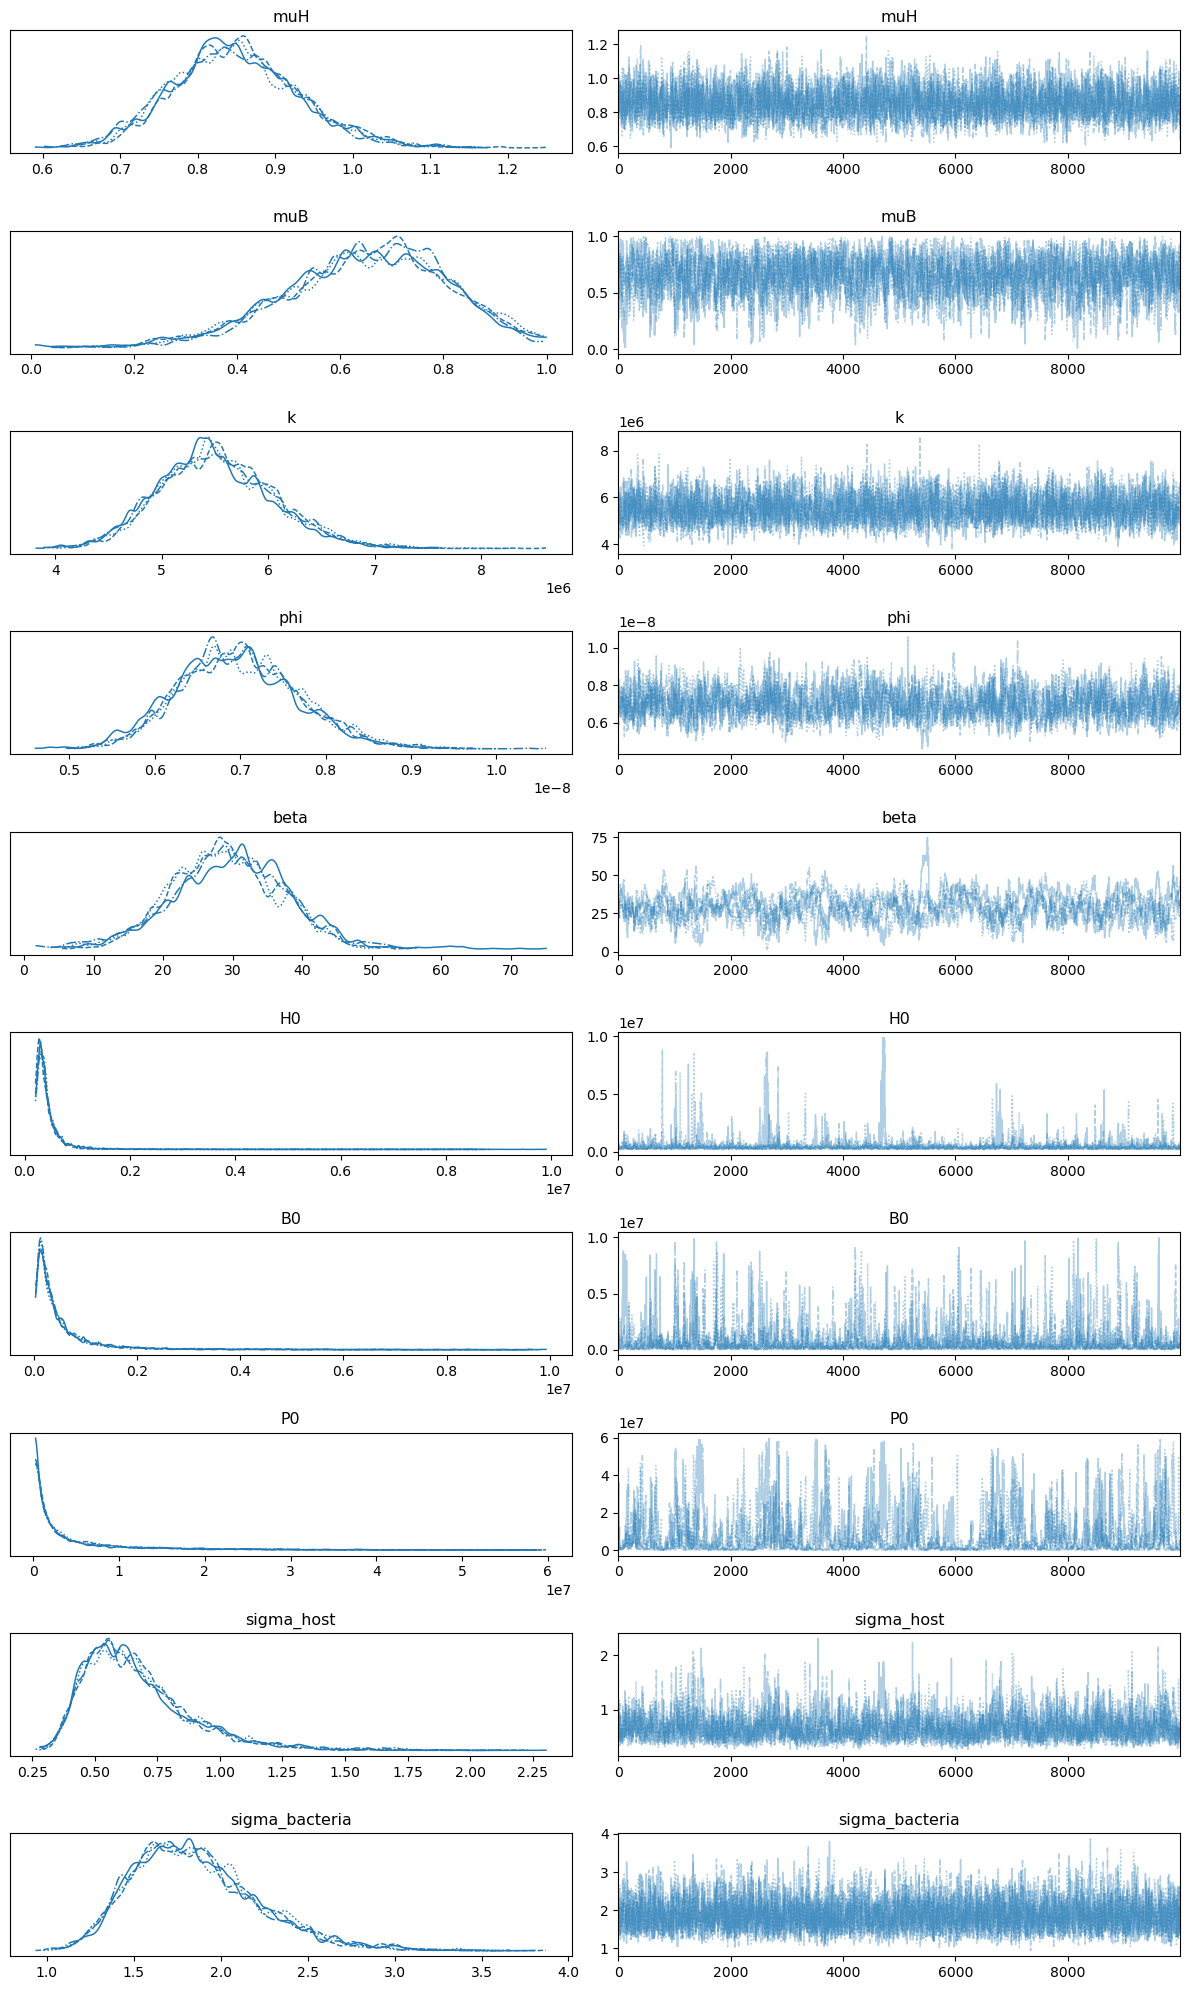

In [24]:
az.plot_trace(trace, 
              #var_names=["muH", "muB", "k", "phi", "beta", "gamma", "H0", "P0", "B0", "sigma_host", "sigma_pathogen", "sigma_bacteria"],
              backend_kwargs={"tight_layout": True})
plt.savefig(save_path + "-trace.png")
plt.show()

## SOME GPT5 Post Processing

In [25]:
def simulate_ode_from_posterior(
    idata,
    time,
    ode_rhs,
    n_draws=100,
    random_seed=None,
):
    import numpy as np
    import arviz as az
    from scipy.integrate import solve_ivp

    rng = np.random.default_rng(random_seed)

    posterior = idata.posterior
    n_chains = posterior.sizes["chain"]
    n_draws_posterior = posterior.sizes["draw"]

    flat_idx = rng.integers(0, n_chains * n_draws_posterior, size=n_draws)
    chain_idx = flat_idx // n_draws_posterior
    draw_idx = flat_idx % n_draws_posterior

    time = np.asarray(time, dtype=float)
    t_span = (time[0], time[-1])

    sims = []

    for c, d in zip(chain_idx, draw_idx):
        muH0 = float(posterior["muH"].values[c, d])
        muB0 = float(posterior["muB"].values[c, d])
        k0      = float(posterior["k"].values[c, d])
        phi0    = float(posterior["phi"].values[c, d])
        beta0  = float(posterior["beta"].values[c, d])

        H00 = float(posterior["H0"].values[c, d])
        P00 = float(posterior["P0"].values[c, d])
        B00 = float(posterior["B0"].values[c, d])

        params_vec = np.array([muH0, muB0, k0, phi0, beta0], dtype=float)
        y0 = [H00, B00, P00]

        sol = solve_ivp(
            lambda t, y: ode_rhs(t, y, params_vec),
            t_span=t_span,
            y0=y0,
            t_eval=time,
            method="LSODA",   # or whatever stiff solver you like
            rtol=1e-6,
            atol=1e-8,
        )

        if not sol.success:
            sims.append(np.full((time.size, 3), np.nan))
        else:
            sims.append(sol.y.T)

    sims = np.stack(sims, axis=0)  # (n_draws, T, 3)
    return sims


In [26]:
import matplotlib.pyplot as plt

def plot_posterior_fit(
    idata,
    time,
    host,
    #d7,
    bacteria,
    ode_rhs,
    n_draws=200,
    log_scale=True,
    random_seed=None,
):
    """
    Plot posterior ODE trajectories over the observed data
    for Host, D7/Pathogen, and Bacteria.
    """
    time = np.asarray(time, dtype=float)
    host = np.asarray(host, dtype=float)
    #d7 = np.asarray(d7, dtype=float)
    bacteria = np.asarray(bacteria, dtype=float)

    sims = simulate_ode_from_posterior(
        idata,
        time,
        ode_rhs,
        n_draws=n_draws,
        random_seed=random_seed,
    )  # (n_draws, T, 3)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

    series = [host, bacteria]
    labels = ["Host", "Bacteria"]

    for i, ax in enumerate(axes):
        y_obs = series[i]
        y_sim = sims[:, :, i]  # (n_draws, T)

        if log_scale:
            y_obs_plot = np.log(y_obs + 1e-9)
            y_sim_plot = np.log(y_sim + 1e-9)
            ax.set_ylabel(f"log {labels[i]}")
        else:
            y_obs_plot = y_obs
            y_sim_plot = y_sim
            ax.set_ylabel(labels[i])

        # scatter observed data
        ax.scatter(time, y_obs_plot, marker="o", alpha=0.8)

        # posterior median and 90% band
        median = np.nanmedian(y_sim_plot, axis=0)
        lower, upper = np.nanpercentile(y_sim_plot, [5, 95], axis=0)

        ax.plot(time, median, linewidth=2)
        ax.fill_between(time, lower, upper, alpha=0.2)

        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    return fig, axes


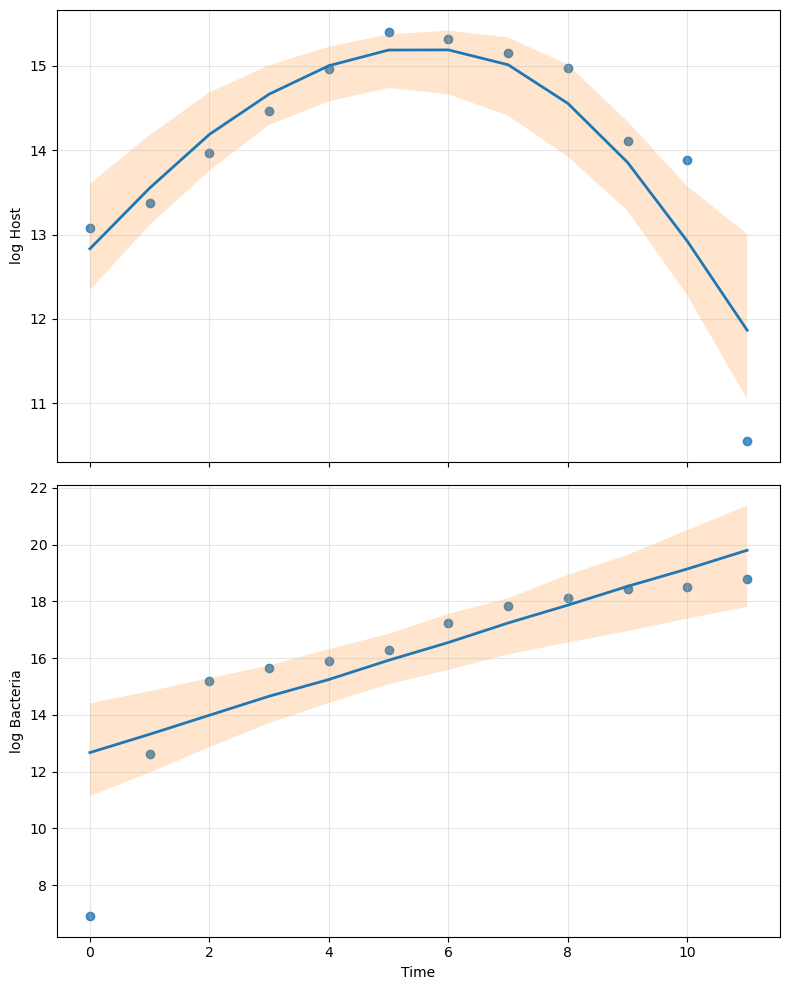

In [27]:
fig, axes = plot_posterior_fit(
    idata=trace,
    time=time,
    host=host,
    #d7=None,
    bacteria=bacteria,
    ode_rhs=ode_system,
    n_draws=200,
    log_scale=True,
    random_seed=42,
)
plt.savefig(save_path + "-posterior-fit.png")
plt.show()